In [11]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import linecache

In [12]:
# set data path
basepath = "/home/emily/Desktop/isamoa_data/"
path = basepath + "good3_sb32n16t_d26min66_irmfit_1458883"

jobid = path[-7:]
filename = path + '/' + jobid + '.log'
print(filename)

/home/emily/Desktop/isamoa_data/good3_sb32n16t_d26min66_irmfit_1458883/1458883.log


# Process data

In [38]:
phase_stats_markers = []

nranks = []
ncells = []
nelaps = []

impi_init = []
impi_probe = []
impi_begin = []
impi_commit = []
impi_adapt = []

####################
# impi exec times
####################

f = open(filename, 'r')
for i, line in enumerate(f,1):
    
    # find all "phase statistics" line numbers
    if "Phase statistics:" in line:
        phase_stats_markers = phase_stats_markers + [i]
        
    # Get nranks & ncells
    if ">>>" in line:
        line = line.split()
        try:
            ranks = int(line[-1])
            cells = int(line[-3][:-1])
            elaps = float(line[-5][:-1])
        except:
            pass
        else: 
            nranks = nranks + [ranks]
            nelaps = nelaps + [elaps]
            ncells = ncells + [cells * ranks]
            
    # Get MPI_Adapt_init time
    if "init_adapt" in line:
        line = line.split()
        idx = line.index("init_adapt")
        try:
            t = float(line[idx+1])
        except:
            pass
        else:
            impi_init = impi_init + [t]

    # Get MPI_Probe_adapt time
    if "probe_adapt" in line:
        line = line.split()
        idx = line.index("probe_adapt")
        try:
            time = float(line[idx+1])
        except:
            pass
        else:
            impi_probe = impi_probe + [time]
            
    # Get MPI_Comm_adapt_begin time
    if "adapt_begin" in line:
        line = line.split()
        idx = line.index("adapt_begin")
        try:
            time = float(line[idx+1])
        except:
            pass
        else:
            impi_begin = impi_begin + [time]

    # Get MPI_Comm_adapt_commit time
    if "adapt_commit" in line:
        line = line.split()
        idx = line.index("adapt_commit")
        try:
            time = float(line[idx+1])
        except:
            pass
        else:
            impi_commit = impi_commit + [time]

    # Get adaption time
    if "Total adaption time" in line:
        line = line.split()
        idx = line.index("=")
        try:
            time = float(line[idx+1])
        except:
            pass
        else:
            impi_adapt = impi_adapt + [time]            
f.close()


####################
# Phase statistics
####################

ps_init_time = 0.0
ps_eq_time = 0.0
ps_tsu_comp_time = 0.0
ps_tsu_adap_time = 0.0
ps_total_time = 0.0

for marker in phase_stats_markers:
    
    # ranks
    line = linecache.getline(filename, marker+2)
    larr = line.split()
    ps_ranks = int(larr[-1])
    
    # Init time
    line = linecache.getline(filename, marker+3)
    larr = line.split()
    idx = larr.index("time:")
    ps_init_time = ps_init_time + float(larr[idx+1])/float(ps_ranks)
    
    # Earthquake time
    line = linecache.getline(filename, marker+4)
    larr = line.split()
    idx = larr.index("time:")
    ps_eq_time = ps_eq_time + float(larr[idx+1])/float(ps_ranks)
    
    # Tsunami compute time
    line = linecache.getline(filename, marker+5)
    larr = line.split()
    idx = larr.index("time:")
    ps_tsu_comp_time = ps_tsu_comp_time + float(larr[idx+1])/float(ps_ranks)
    
    # Tsunami adaption time
    line = linecache.getline(filename, marker+6)
    larr = line.split()
    idx = larr.index("time:")
    ps_tsu_adap_time = ps_tsu_adap_time + float(larr[idx+1])/float(ps_ranks)
    
    # Total time
    line = linecache.getline(filename, marker+13)
    larr = line.split()
    idx = larr.index("time:")
    ps_total_time = ps_total_time + float(larr[idx+1]) 
    
####################
# iMPI times
####################

# Only count completed resource adaptations
n = len(impi_adapt)
impi_begin = impi_begin[:n]
impi_commit = impi_commit[:n]

# Compute total
impi_init_sum = sum(impi_init)
impi_probe_sum = sum(impi_probe)
impi_begin_sum = sum(impi_begin)
impi_commit_sum = sum(impi_commit)
impi_distr_sum = sum(impi_adapt) - impi_begin_sum - impi_commit_sum
impi_total = impi_probe_sum + impi_begin_sum + impi_commit_sum + impi_distr_sum

# Print
print("Averge MPI_Init_adapt: {}".format(impi_init_sum/len(impi_init)))
print("Averge MPI_Probe_adapt: {}".format(impi_probe_sum/len(impi_probe)))
print("Averge MPI_Adapt_begin: {}".format(impi_begin_sum/n))
print("Averge MPI_Adapt_commit: {}".format(impi_commit_sum/n))
print("Averge Data migration: {}".format(impi_distr_sum/n))
print("")
print("Accumulative MPI_Init_adapt: {}".format(impi_init_sum))
print("Accumulative MPI_Probe_adapt: {}".format(impi_probe_sum))
print("Accumulative MPI_Adapt_begin: {}".format(impi_begin_sum))
print("Accumulative MPI_Adapt_commit: {}".format(impi_commit_sum))
print("Accumulative Data migration: {}".format(impi_distr_sum))
print("")
print("Total resource adaptation time: {}".format(impi_total))



Averge MPI_Init_adapt: 0.039
Averge MPI_Probe_adapt: 0.0005730897740112993
Averge MPI_Adapt_begin: 2.775874915
Averge MPI_Adapt_commit: 0.10262674249999999
Averge Data migration: 0.01855104749999996

Accumulative MPI_Init_adapt: 0.039
Accumulative MPI_Probe_adapt: 0.10143688999999997
Accumulative MPI_Adapt_begin: 11.10349966
Accumulative MPI_Adapt_commit: 0.41050696999999997
Accumulative Data migration: 0.07420418999999984

Total resource adaptation time: 11.689647710000001


# # Cells vs. Exec Time

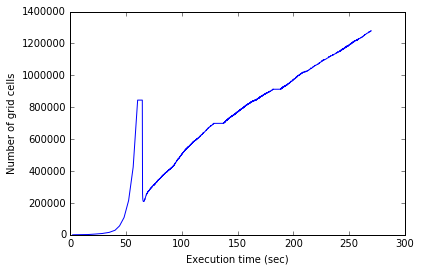

In [52]:
fig = plt.figure()
ax = fig.gca()
ax.plot(nelaps, ncells)
ax.set_xlabel("Execution time (sec)")
ax.set_ylabel("Number of grid cells")

fig.savefig(path+"/cells_vs_time.pdf",bbox_inches="tight")

# # Ranks vs. Exec Time

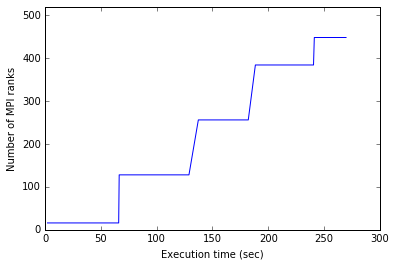

In [53]:
fig = plt.figure()
ax = fig.gca()
ax.plot(nelaps, nranks)
ax.set_xlabel("Execution time (sec)")
ax.set_ylabel("Number of MPI ranks")
ax.set_ylim(0, 520)

fig.savefig(path+"/ranks_vs_time.pdf",bbox_inches="tight")

# Component Runtime

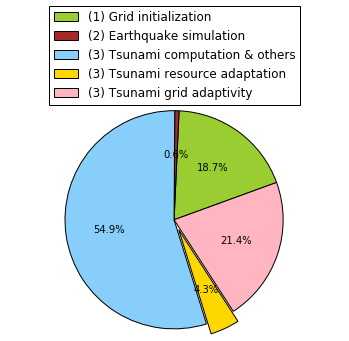

In [56]:
# ps_init_time = 0.0
# ps_eq_time = 0.0
# ps_tsu_comp_time = 0.0
# ps_tsu_adap_time = 0.0
# ps_total_time = 0.0
ps_tsu_compother_time = ps_total_time - ps_init_time - ps_eq_time - ps_tsu_adap_time - impi_total

data = np.array([
    ["(1) Grid initialization", "yellowgreen", ps_init_time, 0],\
    ["(2) Earthquake simulation", "brown", ps_eq_time, 0],\
    ["(3) Tsunami computation & others", "lightskyblue", ps_tsu_compother_time, 0],\
    ["(3) Tsunami resource adaptation", "gold", impi_total, 0.1],\
    ["(3) Tsunami grid adaptivity", "lightpink", ps_tsu_adap_time, 0]
])
labels = data[:,0].tolist()
colors = data[:,1].tolist()
sizes = [float(i) for i in (data[:,2]).tolist()]
explode = [float(i) for i in (data[:,3]).tolist()]

fig = plt.figure()
ax = fig.gca()
patches, texts, autotexts = ax.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', \
        shadow=False, startangle=20)
ax.axis('equal')
lgd = ax.legend(patches, labels, loc="lower center", bbox_to_anchor=(0.5, 1))
fig.savefig(path + "/pine_components.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


# Resource adaptation component view

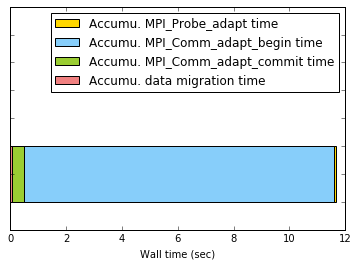

In [57]:
fig = plt.figure()
ax = fig.gca()
width = 1
# Layer 1. probe (bar tip)
data = impi_total
p1 = ax.barh(0, data, width, color='gold', align='center')

# Layer 2. begin 
data = data - impi_probe_sum
p2 = ax.barh(0, data, width, color='lightskyblue', align='center')

# Layer 3. commit
data = data - impi_begin_sum
p3 = ax.barh(0, data, width, color='yellowgreen', align='center')

# Layer 4. distribution (bar root)
data = data - impi_commit_sum
p4 = ax.barh(0, data, width, color='lightcoral', align='center')

ax.set_xlabel('Wall time (sec)')
ax.legend((p1[0], p2[0], p3[0], p4[0]), ('Accumu. MPI_Probe_adapt time', 'Accumu. MPI_Comm_adapt_begin time',\
                            'Accumu. MPI_Comm_adapt_commit time', 'Accumu. data migration time'))
ax.set_ylim(-1, 3)
ax.tick_params(axis='y', which='both', bottom='off', top='off', labelbottom='off',\
               labelleft='off', labeltop='off', labelright='off')

# ax.text(1.4, -0.1, r'$3.22$', fontsize=12)
# ax.text(3.8, -0.1, r'$1.73$', fontsize=12)
# ax.text(5.2, -0.1, r'$1.02$', fontsize=12)
# ax.text(6.2, -0.1, r'$0.08$', fontsize=12)
# plt.plot([total_sum-0.1, total_sum+0.1], [0, 0], 'k-', lw=1)
# ax.text(2.8, 0.9, r'Total adaptation time = $6.06$', fontsize=12)
# plt.plot([total_sum, total_sum], [-1, 0.85], 'k-', lw=1)

fig.savefig(path + "/adaption_breakdown.pdf", bbox_inches='tight')